# 特征设计与模型训练

In [29]:
import pickle

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

from utils import visualization_evaluation,visualization_y
%matplotlib inline

In [30]:
# some parameters
tran_size = 10000

blk_sz, sensitivity = 8, 8
selected_bands = [127, 201, 202, 294]
tree_num = 185
pic_row, pic_col= 600, 1024

dataset_file = f'./dataset/data_{blk_sz}x{blk_sz}_c{len(selected_bands)}_sen{sensitivity}_7.p'
model_file = f'./models/rf_{blk_sz}x{blk_sz}_c{len(selected_bands)}_{tree_num}_7.model'

## 数据集与样本平衡

In [31]:
# 读取数据
with open(dataset_file, 'rb') as f:
    x_list, y_list = pickle.load(f)
# 确保数据当中x和y数量对得上
assert len(x_list) == len(y_list)
print("数据量： ", len(x_list))
x, y = np.asarray(x_list), np.asarray(y_list, dtype=int)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=5,
                                                    shuffle=True, stratify=y)
print(f"x train {x_train.shape}, y train {y_train.shape}\n"
      f"x test {x_test.shape}, y test {y_test.shape}")

数据量：  9819
x train (6873, 8, 8, 4), y train (6873,)
x test (2946, 8, 8, 4), y test (2946,)


total (array([8937.,  600.,   41.,    0.,  190.]), array([0, 1, 2, 3, 4, 5]), <BarContainer object of 5 artists>) 
train (array([6256.,  420.,   29.,    0.,  132.]), array([0, 1, 2, 3, 4, 5]), <BarContainer object of 5 artists>) 
test (array([2681.,  180.,   12.,    0.,   58.]), array([0, 1, 2, 3, 4, 5]), <BarContainer object of 5 artists>)


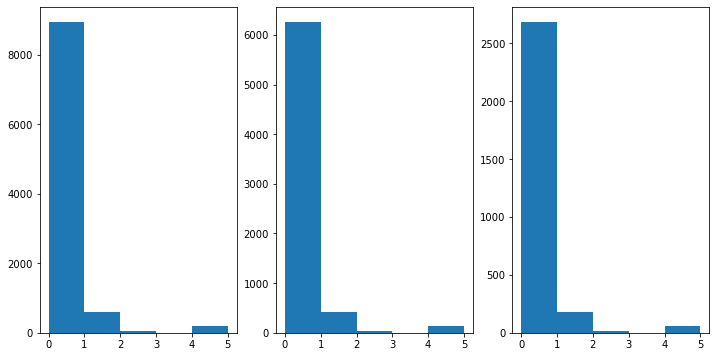

In [32]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6))
hist_res_total = axs[0].hist(y,[0, 1, 2, 3, 4, 5], align='mid')
hist_res_train = axs[1].hist(y_train,[0, 1, 2, 3, 4, 5], align='mid')
hist_res_test = axs[2].hist(y_test,[0, 1, 2, 3, 4, 5], align='mid')
print(f'total {hist_res_total} \n'
      f'train {hist_res_train} \n'
      f'test {hist_res_test}')
plt.show()

train (array([ 6256.,  6256.,  6256.,     0., 12512.]), array([0, 1, 2, 3, 4, 5]), <BarContainer object of 5 artists>) 



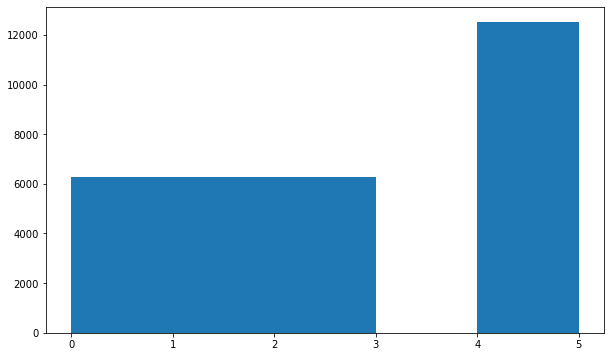

train (array([1666., 1667., 1667.,    0., 3333.]), array([0, 1, 2, 3, 4, 5]), <BarContainer object of 5 artists>) 



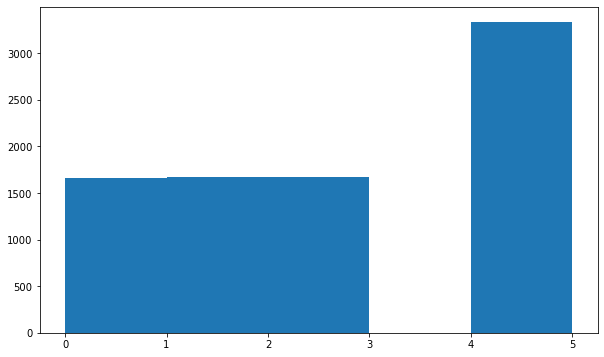

10000


In [33]:
# 发现样本实在是不平衡
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
x_train_shape = x_train.shape
x_train = x_train.reshape((x_train.shape[0], -1))
x_resampled, y_resampled = ros.fit_resample(x_train, y_train)
# 画图
fig, axs = plt.subplots(figsize=(10, 6))
hist_res_train = axs.hist(y_resampled, [0, 1, 2, 3, 4, 5], align='mid')
print(f'train {hist_res_train} \n')
plt.show()
# 抽样
x_train, _, y_train, _ =  train_test_split(x_resampled, y_resampled, train_size=tran_size, random_state=0,
                                           shuffle=True, stratify=y_resampled)
# 画图
fig, axs = plt.subplots(figsize=(10, 6))
hist_res_train = axs.hist(y_train, [0, 1, 2, 3, 4, 5], align='mid')
print(f'train {hist_res_train} \n')
plt.show()
x_train = x_train.reshape(x_train.shape[0], x_train_shape[1], x_train_shape[2], x_train_shape[3])
print(len(x_train))

## 特征设计
设计特征

In [34]:
from models import feature

In [35]:
features_train = feature(x_train)
features_test = feature(x_test)
print(features_test.shape)

(2946, 256)


## 进行训练，验证特征好坏

In [36]:
from models import train_rf_and_report, SpecDetector
feature_x = feature(x)
clf = train_rf_and_report(features_train, y_train, feature_x, y, tree_num, save_path=model_file)

预测时间： 0.1156773567199707
RFC训练模型评分：1.0
RFC待测模型评分：0.9829921580609023
RFC预测结果：[0 0 0 ... 5 5 5]
---------------------------------------------------------------------------------------------------
RFC分类报告
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      8937
           1       0.84      0.98      0.91       600
           2       0.86      0.73      0.79        41
           4       0.97      0.71      0.82        42
           5       0.78      0.91      0.84       148
           6       0.87      0.80      0.84        51

    accuracy                           0.98      9819
   macro avg       0.89      0.85      0.86      9819
weighted avg       0.98      0.98      0.98      9819

RFC混淆矩阵：
[[8827   81    0    0   28    1]
 [   3  590    1    1    5    0]
 [   0    8   30    0    1    2]
 [   0   12    0   30    0    0]
 [   3    8    0    0  134    3]
 [   0    2    4    0    4   41]]
rfc分类报告：
              precision    recall  f1-

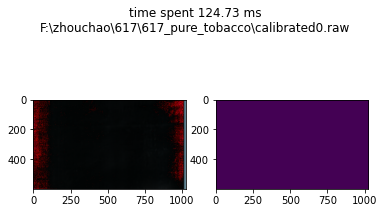

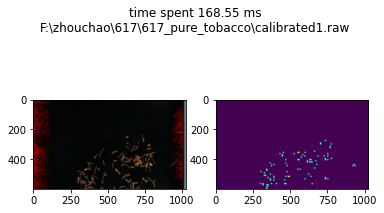

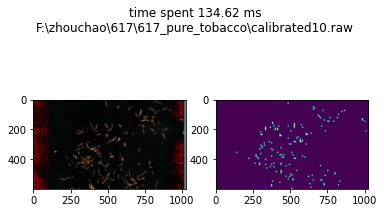

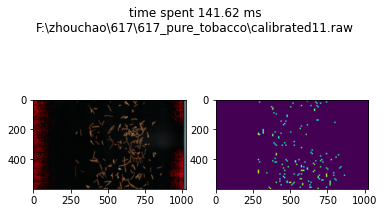

KeyboardInterrupt: 

In [37]:
model = SpecDetector(model_path=model_file, blk_sz=blk_sz, channel_num=len(selected_bands))
# 画图验证效果
visualization_evaluation(detector=model, data_path=r'F:\zhouchao\617\617_pure_tobacco', selected_bands=selected_bands)

In [ ]:
visualization_y(y_list, blk_sz)